# Speech spectrogram 
We have clean and noisy speech files here
http://leap.ee.iisc.ac.in/sriram/teaching/MLSP25/assignments/data/speech.zip
Pick any single wav form.
The files are in wav format sampled at 16kHz. Use library function (librosa mel spectrogram function from librosa tool) to compute the spectrogram features of clean and noisy files (use 20 ms window length with a hop length of 10 ms). The spectrogram should be a matrix of size, D ×T, where D is mel dimension of the spectrogram and T is the duration of audio in ms by 100.

- Assume each time frame of spectrogram is independent of each other. From the
clean files, compute the whitening transform. Apply the transform on spectrogram
feature of a noisy file. Compute the covariance of the whitened spectrogram features
of the noisy file. Is the covariance matrix identity ? Argue the reason for your result.
Repeat the procedure by reversing the roles of clean and noisy files.

- On the clean speech file, using the T features from the clean file, train a 2 mixture
Gaussian model from scratch. Train the model for 20 iterations. Plot the training
log-likelihood function for 20 epochs for two cases i) random initialization, ii) k-means
initialization.


Importing necessary libraries for both parts of the question

In [108]:
from librosa import load
import librosa
from librosa.feature import melspectrogram
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

In [109]:
# from scipy.io import wavfile
# sample_rate, x = wavfile.read('speechFiles/clean.wav')

Reading the files

In [110]:
wav_clean, sf =  load('speechFiles/clean.wav', sr=None)
wav_noisy, sf_noise =  load('speechFiles/noisy.wav', sr=None)
wav_clean.shape

(50000,)

Sampling frequency

In [111]:
sf

16000

Obtaining the spectrogram features using melspectrogram

In [112]:
hop_length = 10*sf//1000
win_length = 20*sf//1000
n_mel = 64 #64
specClean = melspectrogram(y=wav_clean, sr=sf,hop_length=hop_length,win_length=win_length,n_mels=n_mel)
specNoisy = melspectrogram(y=wav_noisy, sr=sf,hop_length=hop_length,win_length=win_length,n_mels=n_mel )
specClean.shape 

x = specClean
x_noise = specNoisy
x.shape
# plt.plot(x[:])

(64, 313)

Plotting the spectrograms for visualization

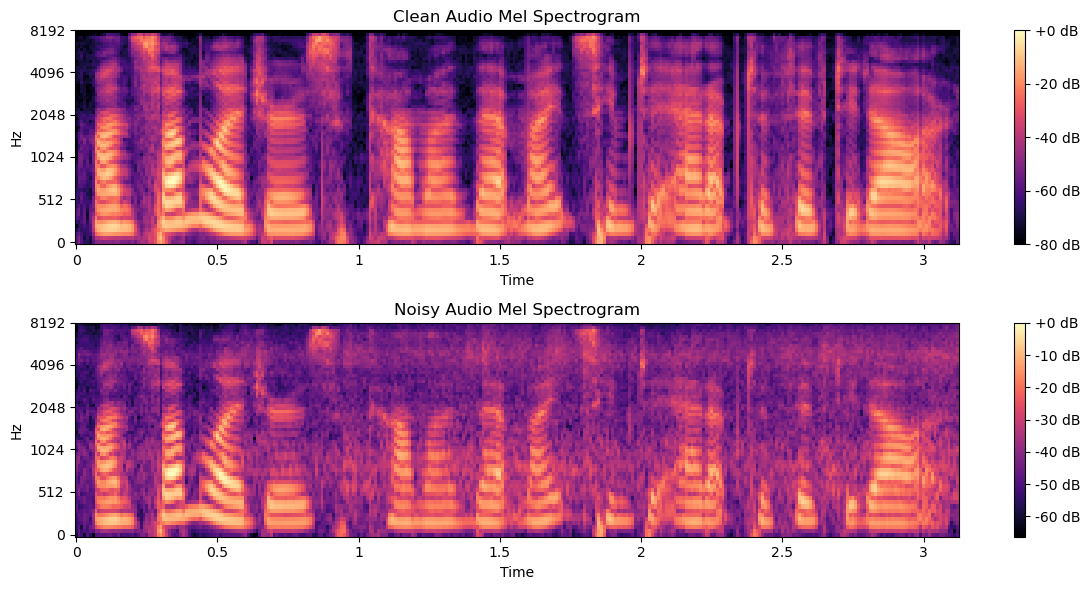

In [113]:

log_specClean = librosa.power_to_db(specClean, ref=np.max)
log_specNoisy = librosa.power_to_db(specNoisy, ref=np.max)

# Plot the spectrograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(log_specClean, sr=sf, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title('Clean Audio Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
librosa.display.specshow(log_specNoisy, sr=sf, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title('Noisy Audio Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

Whitening using Clean and Applied on Clean

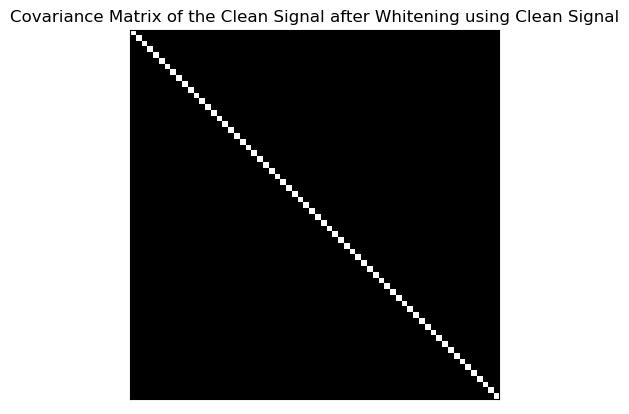

In [114]:
x_centered = x - np.mean(x, axis=0)
Sx = np.cov(x_centered) # Using clean to obtain whitening coeff
U, Lamb, U_T = np.linalg.svd(Sx, full_matrices=False) 
A = U.T
Lamb_inv=np.linalg.inv(np.diag(Lamb))
y = np.sqrt(Lamb_inv)@A@x_centered # Using clean to whiten on clean
Sy = np.cov(y)
plt.imshow(Sy,cmap='gray')
# plt.pcolor(Sy, cmap='viridis', edgecolors='k', linewidths=1)
# plt.colorbar()
plt.title('Covariance Matrix of the Clean Signal after Whitening using Clean Signal')
plt.xticks([])
plt.yticks([])
plt.savefig('covarianceMatrix_clean_clean.pdf', format='pdf')
plt.show()

Upon the whitening transform of **x**, obtained using the following transformation:
$$ y_{\text{transform}} = \Lambda^{\frac{1}{2}}W^T(y-\mu)$$
where $W$ is obtained by the singular value decomposition of the covariance of $x$, ie $S_x$,
this results in "whitening" of the initial data, ie it normalizes the data into zero mean (due to $y-\mu$ where $\mu = \frac{1}{N}\sum_{n=1}^{N}y_n$) and
if $Y$ denotes the transformed variable $y$,

$$
S_Y = \frac{1}{N} \sum_{n=1}^{N} Y_n Y_n^{\top} = \frac{1}{N} \sum_{n=1}^{N} \mathbf{\Lambda}^{-1/2} \mathbf{W}^{\top} (y_n - \mu) (y_n - \mu)^{\top} \mathbf{W} \mathbf{\Lambda}^{-1/2}
\\


= \mathbf{\Lambda}^{-1/2} \mathbf{W}^{\top} \mathbf{S_y} \mathbf{W} \mathbf{\Lambda}^{-1/2} = \mathbf{\Lambda}^{-1/2} \mathbf{\Lambda} \mathbf{\Lambda}^{-1/2} = \mathbf{I}.

$$
 

Obtaining the whitening coefficients from the clean data, when applied on the noisy data doesn't yield a perfect $I$, the identity matrix, since due to noise, since addition of noise changes the eigen decomposition of the covariance matrix $S_y$ and using the same eigen vectors obtained for clean signal retains some cross covariance terms.

Whitening using Noisy applied on Noisy

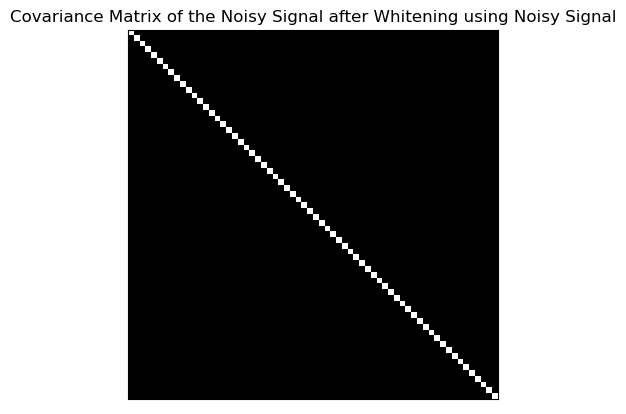

In [115]:
# x_centered = x - np.mean(x, axis=0)
x_noise_centered = x_noise - np.mean(x_noise, axis=0)
Sx = np.cov(x_noise_centered) #Using noisy to obtain whitening coeff
U, Lamb, U_T = np.linalg.svd(Sx, full_matrices=False)
A = U.T
Lamb_inv=np.linalg.inv(np.diag(Lamb))
y = np.sqrt(Lamb_inv)@A@x_noise_centered # Apply on noisy
Sy = np.cov(y)
plt.imshow(Sy,cmap='gray')
plt.title('Covariance Matrix of the Noisy Signal after Whitening using Noisy Signal')
plt.xticks([])
plt.yticks([])

plt.savefig('covarianceMatrix_noisy_noisy.pdf', format='pdf')
plt.show()

Here, since the same eigendecomposition can be used to whiten the noisy signal, it results in the identity matrix $I$.

Whitening using Clean applied on Noisy

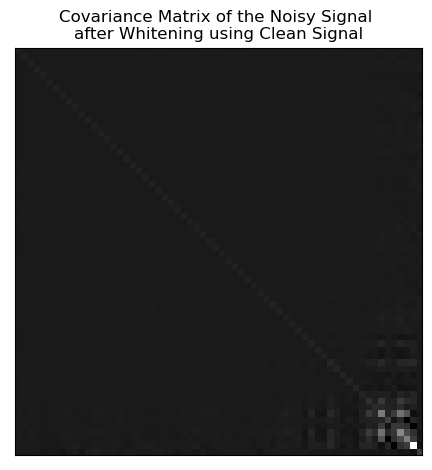

In [116]:
x_centered = x - np.mean(x, axis=0)
x_noise_centered = x_noise - np.mean(x_noise, axis=0)
Sx = np.cov(x_centered) #Using clean to obtain whitening coeff
U, Lamb, U_T = np.linalg.svd(Sx, full_matrices=False)
A = U.T
Lamb_inv=np.linalg.inv(np.diag(Lamb))
y = np.sqrt(Lamb_inv)@A@x_noise_centered # Apply on noisy
# y = y - np.mean(y,axis=0) 
Sy = np.cov(y)

plt.imshow(Sy,cmap='gray')
# plt.pcolor(Sy, cmap='viridis', edgecolors='k', linewidths=1)
# plt.colorbar()
plt.title('Covariance Matrix of the Noisy Signal \nafter Whitening using Clean Signal')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.savefig('covarianceMatrix_clean_noisy.pdf', format='pdf')
plt.show()

Whitening Using Noisy applied on Clean

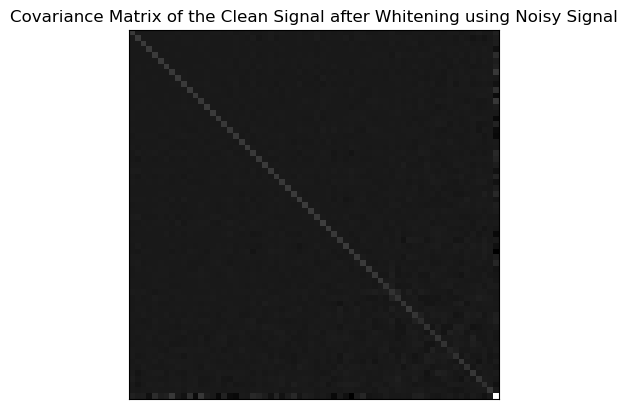

In [117]:
x_centered = x - np.mean(x, axis=0)
x_noise_centered = x_noise - np.mean(x_noise, axis=0)
Sx = np.cov(x_noise_centered) #Using noisy to obtain whitening coeff
U, Lamb, U_T = np.linalg.svd(Sx, full_matrices=False)
A = U.T
Lamb_inv=np.linalg.inv(np.diag(Lamb))
y = np.sqrt(Lamb_inv)@A@x_centered # Apply on clean
Sy = np.cov(y)
plt.imshow(Sy,cmap='gray')
plt.title('Covariance Matrix of the Clean Signal after Whitening using Noisy Signal')
plt.xticks([])
plt.yticks([])

plt.savefig('covarianceMatrix_noisy_clean.pdf', format='pdf')
plt.show()

As with the case when clean signal was used to compute eigendecomposition to be applied on noisy signal, the opposite too results in a covariance matrix which resembles $I$, but has some cross terms resulting in the matrix shown. 
Within the same variables there is a higher correlation than the cross terms, but it is not exactly 1.
Moreover, the transformation when computed from noisy file and applied on clean file results in a covariance matrix which is closer to $I$ can when the opposite is done.
I attempt to explain this by the following: since the noisy file has additive Gaussian noise, upon transformation using coefficients from clean file, the cross correlation terms are more, while in the opposite case, since the transformation is applied on clean file, the cross correlation terms are lower in magnitude.

In [72]:
# x_centered = x - np.mean(x, axis=0)
# x_noise_centered = x_noise - np.mean(x_noise,axis=0)
# # Sx = (x_centered @ x_centered.T) / (x_centered.shape[0] - 1)
# # Sx = np.cov(x_centered)
# Sx = np.cov(x_noise_centered)
# U, Lamb, U_T = np.linalg.svd(Sx, full_matrices=False)
# A = U.T
# print(A.shape)
# Lamb_inv=np.linalg.inv(np.diag(Lamb))
# x_noise_centered = x_noise - np.mean(x_noise, axis=0)
# # y= np.sqrt(Lamb_inv)@A@x_centered
# y = np.sqrt(Lamb_inv)@A@x_noise_centered
# # x_centered = x - np.mean(x, axis=0)
# # y = np.zeros(x_centered.shape)
# # for i in range(len(x_centered)):
#     # y[i] = np.sqrt(Lamb_inv)@A@x_centered[i]
# # y[:] = np.sqrt(Lamb_inv)@A@x_centered[:]
# y_centered = y - np.mean(y, axis=0)
# # Sy = (y_centered.T @ y_centered) / (y_centered.shape[1] - 1)
# Sy = np.cov(y)
# # Sy = np.cov(y_centered)
# plt.imshow(Sy,cmap='gray')
# plt.title('Covariance Matrix of the Noisy Signal after Whitening using Noisy Signal')
# plt.xticks([])
# plt.yticks([])
# plt.show()
# plt.savefig('covarianceMatrix_noise_noise.pdf', format='pdf')


# GMM (Part B)

Reinitializing the data

In [148]:
hop_length = 10*sf//1000
win_length = 20*sf//1000
n_mel = 40 #64
specClean = melspectrogram(y=wav_clean, sr=sf,hop_length=hop_length,win_length=win_length,n_mels=n_mel)
specNoisy = melspectrogram(y=wav_noisy, sr=sf,hop_length=hop_length,win_length=win_length,n_mels=n_mel )
specClean.shape 

x = specClean
x_noise = specNoisy
x.shape
x= x.T
X_clean = x
# plt.plot(x[:])

In [149]:
x.shape

(313, 40)

In [197]:
def kmeans(X, k=2, max_iters=20):
    N, d = X.shape
    indices = np.random.choice(N, k, replace=False)
    centroids = X[indices, :]  # (k, d)
    
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        
        if np.allclose(centroids, new_centroids, atol=1e-6):
            break
        centroids = new_centroids
    
    return centroids[0].reshape(1, d), centroids[1].reshape(1, d)
mean1_k, mean2_k = kmeans(x)
mean1_k.shape

(1, 40)

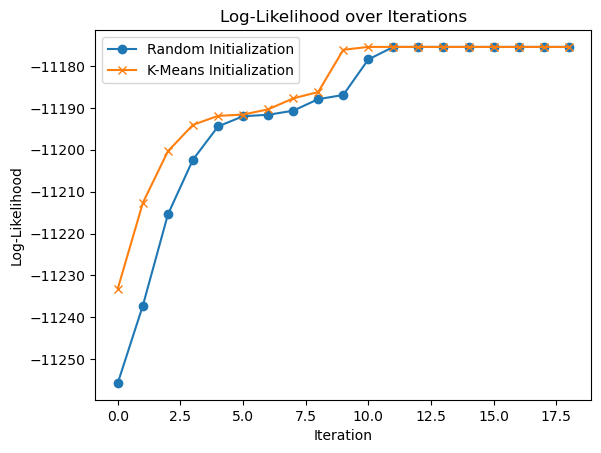

In [ ]:
np.random.seed(11)
# Number of components hardcoded to 2
max_iter = 20
epsilon = 1e-10
# initializing the parameters
alpha = np.log(np.ones((2,1))/2)  # log of alpha
mean1 = np.random.rand(1,x.shape[1])
mean2 = np.random.rand(1,x.shape[1])

variance1 = np.eye(x.shape[1])
variance2 = np.eye(x.shape[1])
x = specClean.T
total_log_likelihood = []
d = x.shape[0]
for iter in range(max_iter):
   
    # E-step
    log_l1 = -0.5 * np.sum((x - mean1) ** 2, axis=0) - 0.5 * np.log(np.linalg.det(variance1) + epsilon) - 0.5 * d * np.log(2 * np.pi)
    log_l2 = -0.5 * np.sum((x - mean2) ** 2, axis=0) - 0.5 * np.log(np.linalg.det(variance2) + epsilon) - 0.5 * d * np.log(2 * np.pi)
    log_denominator = np.logaddexp(np.log(alpha1) + log_l1, np.log(alpha2) + log_l2)
    prob1 = np.exp(np.log(alpha1) + log_l1 - log_denominator)
    prob2 = np.exp(np.log(alpha2) + log_l2 - log_denominator)
    total_log_likelihood.append(np.sum(log_denominator))
    # M step
    # updating the parameters
    mean1 = ((x @ prob1.T) / np.sum(prob1)).reshape(-1, 1)
    mean2 = ((x @ prob2.T) / np.sum(prob2)).reshape(-1, 1)
    X_centered1 = x - mean1
    X_centered2 = x - mean2
    variance1 = (X_centered1 @ np.diag(prob1) @ X_centered1.T) / np.sum(prob1)
    variance2 = (X_centered2 @ np.diag(prob2) @ X_centered2.T) / np.sum(prob2)

    alpha1 = np.sum(prob1) / x.shape[1]
    alpha2 = np.sum(prob2) / x.shape[1]

    variance1 += epsilon * np.eye(d)
    variance2 += epsilon * np.eye(d)
    # print('Iteration: ', iter)
    # print('Alpha: ', np.exp(alpha))  # converting back to original scale for display
    # print('Mu: ', mu)
    # print('Variances: ', variances)
    # print('')

# Using K Means initialization
total_log_likelihood_k = []
mean1 = mean1_k
mean2 = mean2_k
variance1 = np.eye(x.shape[1])
variance2 = np.eye(x.shape[1])
for iter in range(max_iter):
   
    # E-step
    log_l1 = -0.5 * np.sum((x - mean1) ** 2, axis=0) - 0.5 * np.log(np.linalg.det(variance1) + epsilon) - 0.5 * d * np.log(2 * np.pi)
    log_l2 = -0.5 * np.sum((x - mean2) ** 2, axis=0) - 0.5 * np.log(np.linalg.det(variance2) + epsilon) - 0.5 * d * np.log(2 * np.pi)
    log_denominator = np.logaddexp(np.log(alpha1) + log_l1, np.log(alpha2) + log_l2)
    prob1 = np.exp(np.log(alpha1) + log_l1 - log_denominator)
    prob2 = np.exp(np.log(alpha2) + log_l2 - log_denominator)
    total_log_likelihood_k.append(np.sum(log_denominator))
    # M step
    # updating the parameters
    mean1 = ((x @ prob1.T) / np.sum(prob1)).reshape(-1, 1)
    mean2 = ((x @ prob2.T) / np.sum(prob2)).reshape(-1, 1)
    X_centered1 = x - mean1
    X_centered2 = x - mean2
    variance1 = (X_centered1 @ np.diag(prob1) @ X_centered1.T) / np.sum(prob1)
    variance2 = (X_centered2 @ np.diag(prob2) @ X_centered2.T) / np.sum(prob2)

    alpha1 = np.sum(prob1) / X.shape[1]
    alpha2 = np.sum(prob2) / X.shape[1]

    variance1 += epsilon * np.eye(d)
    variance2 += epsilon * np.eye(d)
    # print('Iteration: ', iter)
    # print('Alpha: ', np.exp(alpha))  # converting back to original scale for display
    # print('Mu: ', mu)
    # print('Variances: ', variances)
    # print('')

# Plot log-likelihood
plt.plot(total_log_likelihood[1:], label='Random Initialization', marker='o')
plt.plot(total_log_likelihood_k[1:], label='K-Means Initialization', marker='x')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.legend()
plt.title('Log-Likelihood over Iterations')
plt.show()

It can be observed that the initialization using k-means converges faster (2 iterations before) the random initialization from this graph.

---
Subsequent part of the document contains codes which didn't work but has been included to show the methods tried. (You can ignore this part).

In [105]:
# GMM definitions which didnt work

class GMM:
    def __init__(self, n_components=2, max_iter=20, tol=1e-3, initialization='random'):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.initialization = initialization
    def initialize(self,X):
        '''Initializes the parameters of the GMM model, default is random initialization'''
        if self.initialization=='kmeans':
            pass
        elif self.initialization=='random':
            self.alpha = np.ones((self.n_components,1))/self.n_components
            self.means = np.random.choice(X, self.n_components)
            self.variances = [np.zeros((len(X[0]),len(X[0])))]*self.n_components

        else:
            raise ValueError('Invalid initialization method')
    def expectation(self,X):
        '''Expectation step'''
        self.Q = np.zeros((len(X),self.n_components))
        for i in range(len(X)):
            for j in range(self.n_components):
                self.Q[i,j] = self.alpha[j]*multivariate_normal.pdf(X[i], self.means[j], self.variances[j])
            self.Q[i] /= np.sum(self.Q[i])
    def maximization(self,X):
        '''Maximization step'''
        for j in range(self.n_components):
            self.alpha[j] = np.sum(self.Q[:,j])/len(X)
            self.means[j] = np.sum(self.Q[:,j]*X)/np.sum(self.Q[:,j])
            self.variances[j] = np.sum(self.Q[:,j]*(X-self.means)@(X-self.means).T)/np.sum(self.Q[:,j])
    def compute_log_likelihood(X, Q,alpha, means, variances, n_components):

        '''Compute the log-likelihood of the data X under the current model'''
        log_likelihood = 0
    
        for j in range(n_components):
            rv = multivariate_normal(mean=means[j], cov=variances[j],)
            for i in range(len(X)):
                log_likelihood += Q[i,j]*(np.log(alpha[j]) + rv.logpdf(X[i]))+10e-5
            #     likelihood += alpha[j] * multivariate_normal.pdf(X[i], means[j], variances[j])
            # log_likelihood += np.log(likelihood)
        return log_likelihood

    def fit(self,X, n_components, max_iter, tol, initialization):
        '''Fit the GMM model to the data X'''
        alpha, means, variances = self.initialize(X, n_components, initialization)
        log_likelihoods = []
        for i in range(max_iter):
            mean = means.copy()
            # E-step
            Q = self.expectation(X, alpha, means, variances, n_components)
            # M-step
            alpha, means, variances = self.maximization(X, Q, n_components)
            # Compute log-likelihood
            log_likelihood = self.compute_log_likelihood(X, alpha, means, variances, n_components)
            log_likelihoods.append(log_likelihood)
            # Check for convergence
            if np.linalg.norm(means - mean) < tol:
                break
        return alpha, means, variances, log_likelihoods

In [106]:
# class GMM:
#     def __init__(self, n_components=2, max_iter=20, tol=1e-3, initialization='random'):
#         self.n_components = n_components
#         self.max_iter = max_iter
#         self.tol = tol
#         self.initialization = initialization
#         self.log_likelihoods = []

#     def initialize(self, X):
#         '''Initializes the parameters of the GMM model, default is random initialization'''
#         if self.initialization == 'kmeans':
#             pass
#         elif self.initialization == 'random':
#             self.alpha = np.ones((self.n_components)) / (self.n_components+10e-8)
#             indices = np.random.choice(len(X), self.n_components, replace=False)
#             self.means = X[indices]
#             self.variances = [np.eye(len(X[0]))] * self.n_components
#         else:
#             raise ValueError('Invalid initialization method')


#     def expectation(self, X):
#         '''Expectation step'''
#         self.Q = np.zeros((len(X), self.n_components))
#         for i in range(len(X)):
#             for j in range(self.n_components):
#                 self.Q[i, j] = self.alpha[j] * multivariate_normal.pdf(X[i], self.means[j], self.variances[j])
#             # self.Q[i] /= np.sum(self.Q[i])

#     def maximization(self, X):
#         '''Maximization step'''
#         for j in range(self.n_components):
#             self.alpha[j] = np.sum(self.Q[:, j]) / len(X)
#             self.means[j] = np.sum(self.Q[:, j][:, np.newaxis] * X, axis=0) / np.sum(self.Q[:, j])
#             self.variances[j] = np.dot((self.Q[:, j][:, np.newaxis] * (X - self.means[j])).T, (X - self.means[j])) / np.sum(self.Q[:, j])
#             self.variances[j]+=np.eye(len(variances[j]))*10e-5

#     def compute_log_likelihood(self, X):
#         '''Compute the log-likelihood of the data X under the current model'''
#         log_likelihood = 0
#         for i in range(len(X)):
#             likelihood = 0
#             for j in range(self.n_components):
#                 likelihood += self.alpha[j] * multivariate_normal.pdf(X[i], self.means[j], self.variances[j])
#             log_likelihood += np.log(likelihood)+10e-5
#         return log_likelihood

#     def fit(self, X):
#         '''Fit the GMM model to the data X'''
#         self.initialize(X)
#         for i in range(self.max_iter):
#             mean = self.means.copy()
#             # E-step
#             self.expectation(X)
#             # M-step
#             self.maximization(X)
#             # Compute log-likelihood
#             log_likelihood = self.compute_log_likelihood(X)
#             self.log_likelihoods.append(log_likelihood)
#             # Check for convergence
#             # if np.linalg.norm(self.means - mean) < self.tol:
#             #     break

# # Assuming x is your data
# # x = np.loadtxt('path/to/clean_speech_file.txt')  # Load your data here


In [27]:
gmm = GMM(n_components=2, max_iter=20, initialization='random')
gmm.fit(x)

# Plot the training log-likelihood function
plt.plot(range(1, len(gmm.log_likelihoods) + 1), gmm.log_likelihoods)
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood')
plt.title('Training Log-Likelihood')
plt.show()

ValueError: array must not contain infs or NaNs

In [116]:
mixture = GMM(n_components=2)
mixture.fit(x)

c:\Users\suvam\.conda\envs\img_processing\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

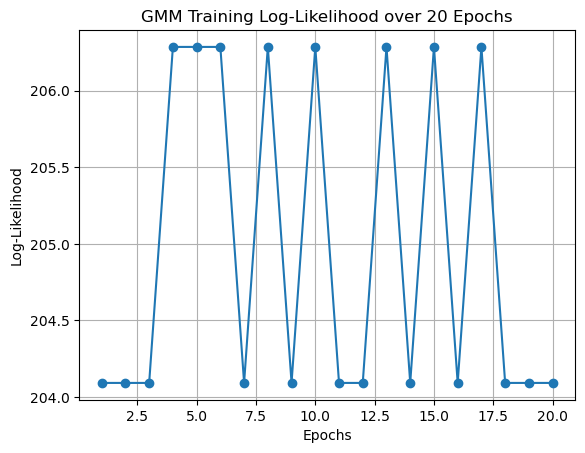

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming x is given (shape: 128,313)
# Replace this with actual data
# x = np.random.rand(128, 313)  # Example random data
x=specClean
x = x.T  # Shape should be (313, 128) for sklearn

# Fit Gaussian Mixture Model with 2 components
n_components = 2
max_iter = 20
log_likelihoods = []

# gmm = GaussianMixture(n_components=n_components, max_iter=20,init_params='random')
gmm = GaussianMixture(n_components=n_components, max_iter=20,init_params='kmeans')
for i in range(max_iter):
    gmm.fit(x)
    log_likelihoods.append(gmm.lower_bound_)

# Plot log-likelihood function
plt.plot(range(1, max_iter + 1), log_likelihoods, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Log-Likelihood")
plt.title("GMM Training Log-Likelihood over 20 Epochs")
plt.grid()
plt.show()